# Practical Machine Learning for Physicists
## Introduction to image compression

In this notebook we are going to be using the simple neural network class that we used last time to explore some of the possibilities of using neural networks for image recogintion and image compression.


This notebook was heavily inspired by the https://machine-learning-for-physicists.org course. There is lots of excellent background material on that site and like the original notebooks these notebooks are released under the creative commons license.




In this notebook we are going to learn how to:
- Use a network to approximate an image
- Show examples of how to understand what the various components of the network are doing by switching off some of the neurons.

In [1]:
# Up front we always have to import numpy and pyplot and do some style setting
import numpy as np  #import the numpy library as np
import matplotlib.pyplot as plt #import the pyplot library as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

# import some image handling/loading libraries
from scipy import ndimage # for image loading/processing
import imageio

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

In [2]:
#Here we define our simple neural network wrapped up in a python class for tidyness
class SimpleNN:
    """A simple neural network class"""
    #Define and initialise our class variables  
    def __init__(self,nLayers,nBatch,layerSize,useRELU=False,wMax=1,bMax=1):
        self.nlayers=nLayers
        self.batchsize=nBatch
        self.layersize=layerSize
        self.useRELU=useRELU
        
        #Initialise the weights and biases with random numbers
        #self.w=[np.random.uniform(low=-1*wMax,high=+1*wMax,size=[ self.layersize[j],self.layersize[j+1] ]) for j in range(self.nlayers)]
        #self.b=[np.random.uniform(low=-1*bMax,high=+1*bMax,size=[ self.layersize[j+1] ]) for j in range(self.nlayers)]
        self.w=[wMax*(1./np.sqrt(self.layersize[j]))*np.random.randn(self.layersize[j],self.layersize[j+1]) for j in range(self.nlayers)]
        self.b=[bMax*np.random.randn(self.layersize[j+1]) for j in range(self.nlayers)]
        
        #Define the arrays for various outputs needed for backpropagation
        self.yArray=[np.zeros([self.batchsize,self.layersize[j]]) for j in range(self.nlayers+1)]
        self.dfArray=[np.zeros([self.batchsize,self.layersize[j+1]]) for j in range(self.nlayers)]
        self.dwArray=[np.zeros([self.layersize[j],self.layersize[j+1]]) for j in range(self.nlayers)]
        self.dbArray=[np.zeros(self.layersize[j+1]) for j in range(self.nlayers)]
    
    
    #This function evaluates both the neuron output funciton f(x), but also gets df/dx(x)
    def get_f_df_sigmoid(self,x):  
        emx=np.exp(-x) 
        f=1./(1+emx) #Sigmoid
        df=emx*f*f #df/dx
        return (f,df) #Return both
    
    # For a change: Set up rectified linear units (relu) 
    # instead of sigmoid
    def get_f_df_relu(self,z): # calculate f(z) and f'(z)
        val=z*(z>0)
        return(val,z>0) # return both f and f'

    #Evaluate one layer step of the network 
    def forward_step(self,y,w,b):
        z=np.dot(y,w)+b  #Calculate z from the inputs, weights and biases
        #Remember y has shape (Nbatch x Layer Size N)
        # w has shape (Layer Size N x Layer Size N+1)
        # b has shape (Layer Size N+1)
        # z has shape (Nbatch x Layer Size N+1) 
        if(self.useRELU):
            return self.get_f_df_relu(z) #Get f(z) and df/dz(z)
        return self.get_f_df_sigmoid(z) #Get f(z) and df/dz(z)

    def network_forward(self,yin):
        y=yin # start with input values which have shape (batch size x input layer size)
        self.yArray[0]=y 
        for i in range(self.nlayers):  #Loop over the self.nlayers of the network
            y,df=self.forward_step(y,self.w[i],self.b[i]) #Take one step forward in the network
            self.yArray[i+1]=y   #Store y for backpropagation
            self.dfArray[i]=df #Stor df for backpropagation
        return y
    
    def backward_step(self,delta,w,df):
        #delta is the error at layer N of shape (Nbatch x layer N output size)
        #w is the weights at layer N of shape (layer N-1 output size x layer N output size)
        #df has shape (Nbatch x layer N-1 output size)
        return (np.dot(delta,np.transpose(w))*df)

    def backpropagate(self,yTarget):
        #This function fills the dwArray and dbArray arrays with the gradients at each layer
    
        #Evaluate error at last layer
        delta=(self.yArray[-1]-yTarget)*self.dfArray[-1]
        self.dwArray[-1]=np.dot(np.transpose(self.yArray[-2]),delta)/self.batchsize
        self.dbArray[-1]=delta.sum(0)/self.batchsize
        for i in range(self.nlayers-1):
            delta=self.backward_step(delta,self.w[-1-i],self.dfArray[-2-i])
            self.dwArray[-2-i]=np.dot(np.transpose(self.yArray[-3-i]),delta)/self.batchsize
            self.dbArray[-2-i]=delta.sum(0)/self.batchsize
            
    #Update the weights and biases using the gradients and learning rate (eta)
    def update_with_gradients(self,eta):
        for i in range(self.nlayers):
            self.w[i]-=eta*self.dwArray[i]
            self.b[i]-=eta*self.dbArray[i]
   
    #Function that evaluates one pass through the network using input yIn
    #Then backpropagates the errors through the network to update the weights and biases
    def train_network(self,yIn,yTarget,eta):
        yOut=self.network_forward(yIn)
        self.backpropagate(yTarget)
        self.update_with_gradients(eta)
        cost=((yTarget-yOut)**2).sum()/self.batchsize
        return(cost)
    
   

## Train a network to reproduce an arbitrary 2D function

In [3]:
#Need to load our image
input_img = imageio.imread('Smiley.png')
pixel_image=np.transpose(input_img[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=pixel_image.min()
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image)[0] # assuming a square image!
print("The image is "+str(np.shape(pixel_image)[0])+" X "+str(np.shape(pixel_image)[1])+" pixels")



The image is 194 X 194 pixels


In [4]:
#Now need to wrap the image in a function for easy calling
def imgFunction(x,y):
    global pixel_image,Npixels
    # convert to integer coordinates (assuming input is 0..1)
    xint=(x*Npixels*0.9999).astype(dtype='int')
    yint=(y*Npixels*0.9999).astype(dtype='int')
    return(pixel_image[xint,yint]) # extract color values at these pixels




(-0.5, 49.5, -0.5, 49.5)

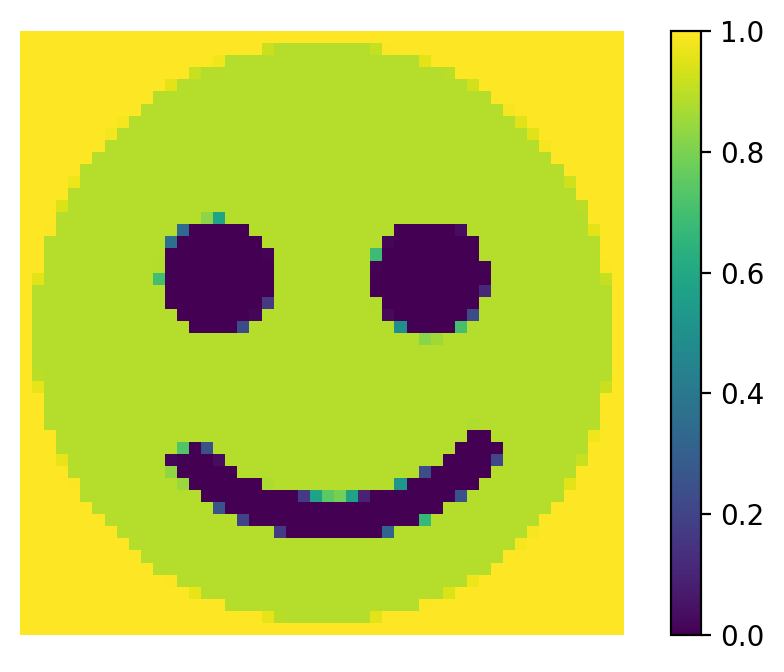

In [5]:
# Check that we can actually plot the image
Npixels_Test=50 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test) #e.g. 50 steps from 0,1
X0,X1=np.meshgrid(xrange,xrange) #get the 2D grid points
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
im=ax.imshow(imgFunction(X0,X1),interpolation='nearest',origin='lower')
cb = fig.colorbar(im) #Get the colorbar for the range of z values
ax.axis('off')

In [6]:
#Need to define the network
myNN = SimpleNN(nLayers=3,nBatch=100,layerSize=[2,20,30,1])

## Use random batches

In [7]:
#Define a new fresh network
myNN = SimpleNN(nLayers=3,nBatch=1000,layerSize=[2,150,100,1],useRELU=False,wMax=5,bMax=0)

In [8]:
#This function picks batchsize random x,y pairs and then evaluates myFunc for these x,y pairs
# returns both the x,y pairs and the values
def make_batch(batchsize):
    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    targets=np.zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=imgFunction(inputs[:,0],inputs[:,1])
    return(inputs,targets)

(-0.5, 0.5, -0.5, 0.5)

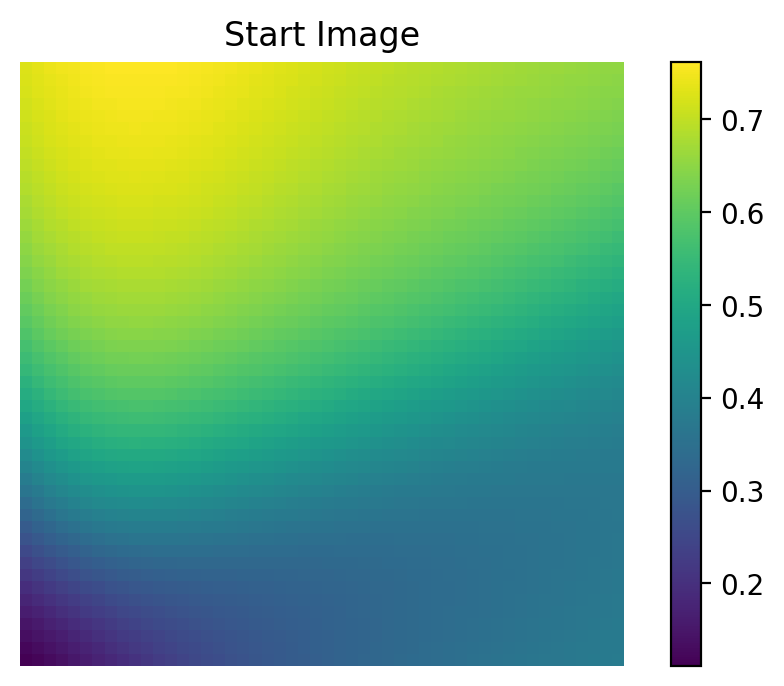

In [9]:
# try to evaluate the (randomly initialized) network
# on some area in the 2D plane
test_batchsize=np.shape(X0)[0]*np.shape(X0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()
#print(testsample)

testoutput=myNN.network_forward(testsample)
fig, ax = plt.subplots()
myim=ax.imshow(np.reshape(testoutput,np.shape(X0)),extent=(-0.5,0.5,-0.5,0.5),origin='lower',interpolation='none')
ax.set_title("Start Image")
cb = fig.colorbar(myim) #Get the colorbar for the range of z values
ax.axis('off')

Text(0.5, 0, 'Step Number')

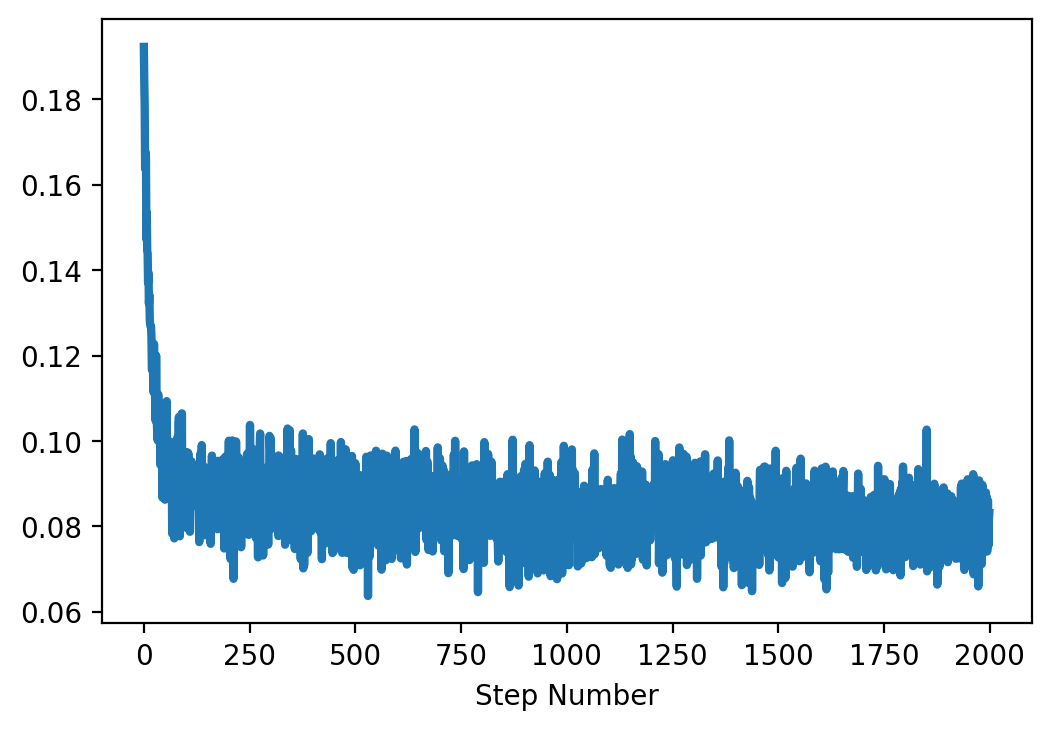

In [10]:
#Define our learning rate and number of learning steps and make an array for the cost function per step
eta=.01
steps=2000
cost=np.zeros(steps)

#Loop through the steps, get a random batch of samples, train the network, repeat
for k in range(steps):
    y_in,y_target=make_batch(myNN.batchsize)
    cost[k]=myNN.train_network(y_in,y_target,eta)
    #print(y_target)

#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number")


Text(0.5, 1.0, 'Current Network Image')

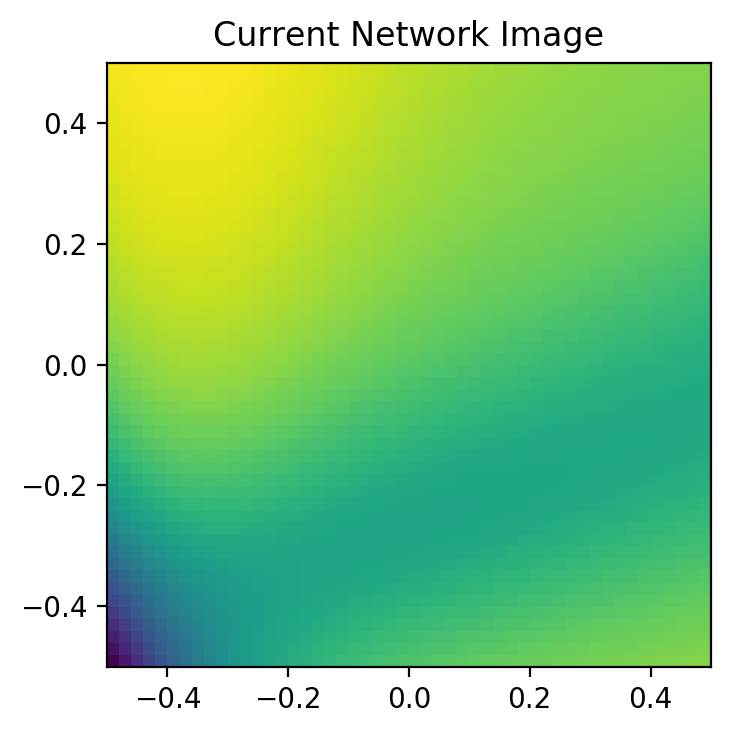

In [11]:
#Now plot the final result... does it look somewhat like the input image?
testoutput=myNN.network_forward(testsample)
fig, ax = plt.subplots()
myim=ax.imshow(np.reshape(testoutput,np.shape(X0)),extent=(-0.5,0.5,-0.5,0.5),origin='lower',interpolation='none')
ax.set_title("Current Network Image")


# How quickly can you learn how to learn?

## Animating the learning process

Typically we need to take about a million samples from the image in order to train our network to at least resemble the input image (i.e. look vaguely similiar). You can try and change various parameters such as the learning rate, batchsize and weight initialisation (done above in the constructor for SimpleNN) to see if you can optimise any of these parameters to converge at a 'successful' image using fewer samples.

In [25]:
# start fresh by making a new neural network object
myNN=SimpleNN(nLayers=3,nBatch=100,layerSize=[2,100,100,1],useRELU=False,wMax=5,bMax=0)

In [26]:

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

# test sample
Npixels_Test=30 # do the test output on a low-res grid! (saves time)
xrange=np.linspace(0,1,Npixels_Test)
X0,X1=np.meshgrid(xrange,xrange)
test_batchsize=np.shape(X0)[0]*np.shape(X0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

# parameters
eta=1.0
nsteps=10000
nskip_steps=100
cost=np.zeros(nsteps)
samples_count=0


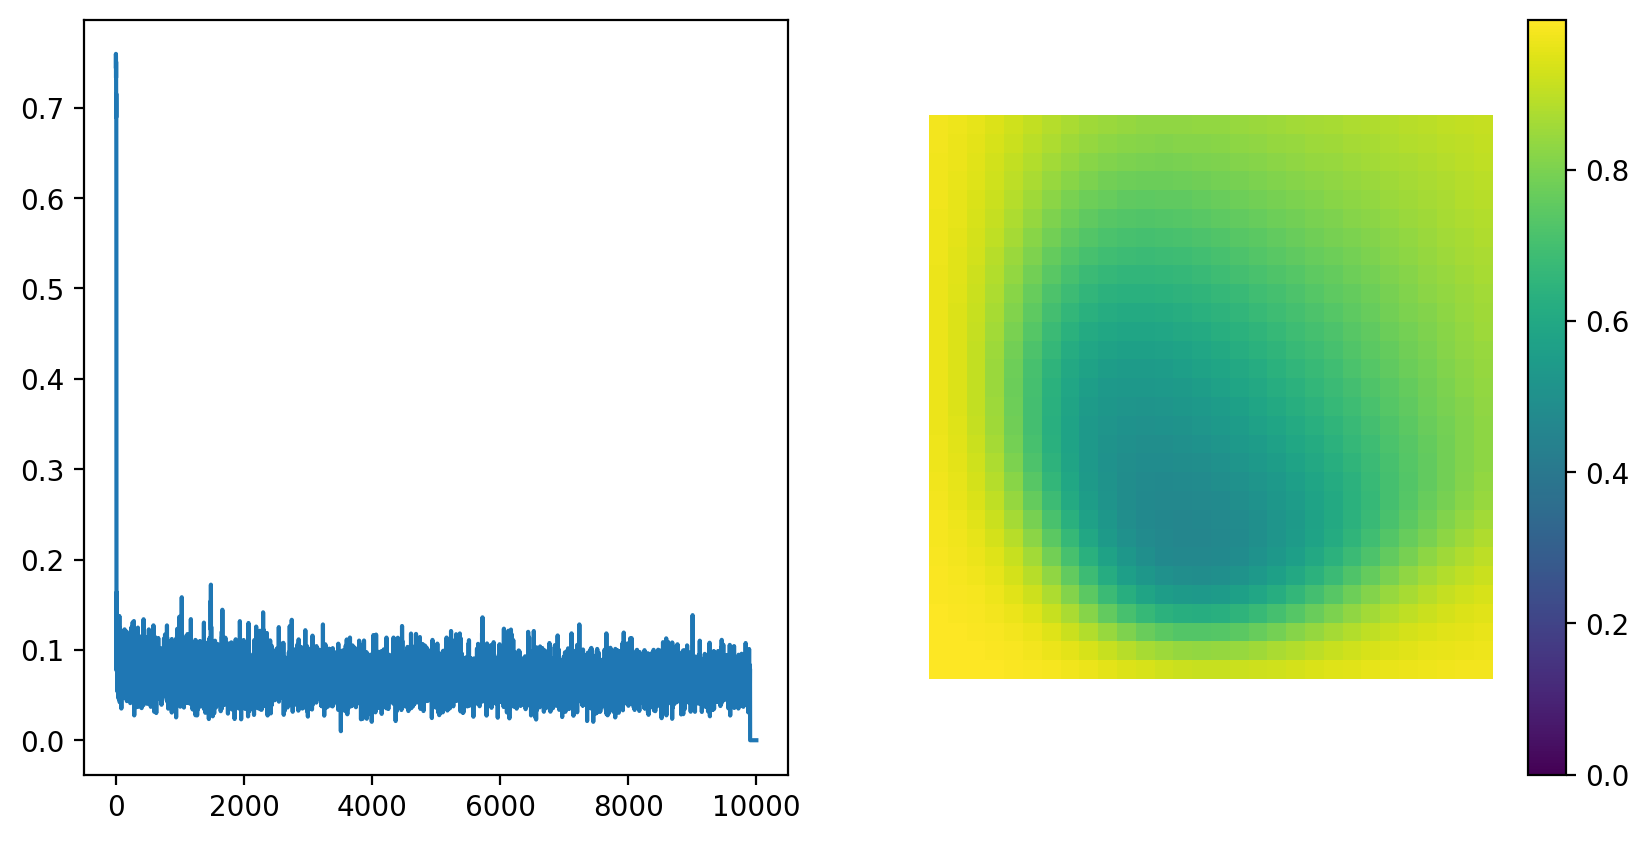

In [27]:
#You can keep rerunning this cell and see if the image gets closer to the smiley face
cost=np.zeros(nsteps)

#Loop through the steps, get a random batch of samples, train the network, repeat
for j in range(nsteps):
    y_in,y_target=make_batch(myNN.batchsize)
    cost[j]=myNN.train_network(y_in,y_target,eta)
    samples_count+=myNN.batchsize
    if j%nskip_steps==0: # time to plot again!
        testoutput=myNN.network_forward(testsample)  
        clear_output(wait=True)
        fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
        img=ax[1].imshow(np.reshape(testoutput,np.shape(X0)),origin='lower',interpolation='nearest',vmin=0)
        fig.colorbar(img,ax=ax[1])
        ax[1].axis('off') # no axes
        ax[0].plot(cost)
        plt.show() #Need to have the plot show if we are using the clear_output for animation


AllOldWeights=myNN.w # backup all weights
OldWeights=myNN.w[-1] # especially of last layer, which we will modify below!

In [22]:
samples_count

5000000

(-0.5, 299.5, -0.5, 299.5)

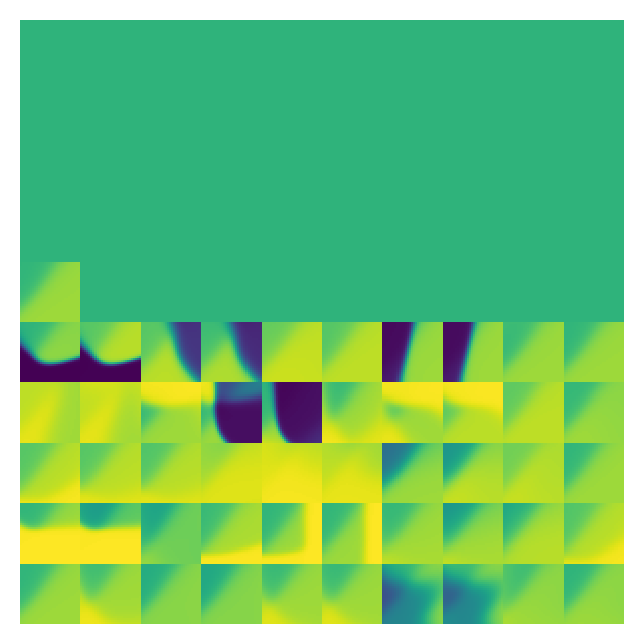

In [24]:
# switch on only individual neurons of last hidden layer
# and plot the resulting pictures in a big 10x10 array!
Nrow=10

BigImage=np.zeros([Nrow*Npixels_Test,Nrow*Npixels_Test])
for which in range(100):
    myNN.w[-1]=OldWeights.copy()
    myNN.w[-1][0:which-1,:]=0
    myNN.w[-1][which+1:-1,:]=0
    testoutput=myNN.network_forward(testsample)
    row=int(which/Nrow)
    column=which%Nrow
    BigImage[Npixels_Test*row:Npixels_Test*(row+1),Npixels_Test*column:Npixels_Test*(column+1)]=np.reshape(testoutput,np.shape(X0))
    #print(row,column)

fig,ax = plt.subplots()    
ax.imshow(BigImage,origin='lower',interpolation='nearest',vmin=0.0,vmax=1.0)
ax.axis('off')
